In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

%run ../sim_utilities.py


import bandits_lab.bandit_definitions as bands
import bandits_lab.algorithms as algs

<Figure size 640x480 with 0 Axes>

In [111]:
np.set_printoptions(precision=2)

In [112]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
#%run ../sim_utilities.py
data_dict = load_data_dict('../data_saves/diversity/log_or_bounded_regret.pkl')
plot_and_save(data_dict, save_data=False, skip_algs=[], log_scale=True, clean=False)

plt.tight_layout()
plt.savefig('log_v_bounded_results.pdf')

#print('worst possible perf : ',str(T*delta_max))

FileNotFoundError: [Errno 2] No such file or directory: '../data_saves/diversity/log_or_bounded_regret.pkl'

In [122]:
def plot_and_save(
    data_dict,
    save_figure=False,
    skip_algs=[],
    log_scale=True,
    show_vars=True,
    clean=False,
    **kwargs,
):
    colors = plt.get_cmap("tab10").colors
    T = data_dict["T"]
    if "t_slice" in kwargs:
        t_slice = kwargs["t_slice"]
    else:
        t_slice = range(T)
    nplots = len(data_dict["band_list"])
    fig, axes = plt.subplots(nrows=1, ncols=nplots, figsize=(16, 4), sharey="all")
    for i, band in enumerate(data_dict["band_list"]):
        ax = axes[i]
        for j, alg in enumerate(data_dict["alg_list"]):
            if j in skip_algs or not (data_dict["ended"][i][j]):
                continue
            mean_reg, var_reg = data_dict["results"][i][j]
            if "rescale" in kwargs.keys():
                if kwargs["rescale"]:
                    mean_reg = np.array(mean_reg) / data_dict["scales"][i]
                    var_reg = np.array(var_reg) / np.square(data_dict["scales"][i])
            if log_scale:
                ax.set_xscale("log")  # , nonposx='clip')
            ax.set_title(r'$p^*=$' + str(band.p_star))
            ax.plot(
                t_slice, mean_reg[t_slice], label=alg.label, color=colors[j],
            )
            if show_vars:
                sig = np.sqrt(var_reg[t_slice] / data_dict["N_tests"][i])
                ax.fill_between(
                    t_slice,
                    mean_reg[t_slice] + 2 * sig,
                    mean_reg[t_slice] - 2 * sig,
                    alpha=0.3,
                    color=colors[j],
                )
        
        ax.legend(loc=2, prop={'size': 15})
        

    if save_figure:
        plt.tight_layout()
        # save_data_dict(data_dict)
        path = uniquify(data_dict["short_name"] + ".pdf")
        plt.savefig(path, format="pdf")
        
        
        


# Sphere Constraints 
 - conjecture : logarithmic regret ? 
 - careful : does not work when the circle is larger than the simplex !!!

In [70]:
np.random.seed(4)

K = 10

mus = np.random.rand(K)
noise='bernoulli'

#r = 1/(2*K)
r = np.sqrt(1 + 1/(K-1))/K #maximal radius included in the simplex
r2 = (np.sqrt(1 + 1/(K-1))/K)*0.9
C = bands.SphereConstraints(K, r)

band_list = [bands.DivPBand(K, mus, C, noise=noise),
            ]

N_tests = [5 for _ in band_list]


delta_max = [band.setP.argmax_dot(mus).fun -(- band.setP.argmax_dot(-mus).fun) for band in band_list]
print(delta_max)

[0.21947253070681688]


In [71]:
T = 3000

eps = 1.
alg_list = [#FairUCB(K, C, label='Div-kl-UCB', noise="bernoulli"),
            algs.DivPUCB(K, C, label='Div-UCB', noise="gaussian"),
            algs.L1OFUL(K, C, label="L1OFUL", delta=1/T),
            algs.DivPEpsGreedy(K, C, label=r'$\epsilon$-greedy, $\epsilon =$'+str(eps), epsilon=eps), 
            algs.DivPEpsGreedy(K, C, label="FTL", epsilon=0)
           ]


skips = []
data_dict={
    'name':'Diversity-preserving bandits with a spherical probability set',
    'short_name':'fair',
    'T':T,
    'N_tests':N_tests,
    'band_list':band_list,
    'alg_list':alg_list,
    'results':None,
    'seed':0,
    'folder':'../figures/testing/',
}


launch(data_dict, checkpoints=False)


plot_and_save(data_dict,
                save_figure=False,
                skip_algs=skips,
                log_scale=True,
                show_vars=True,
                )


Div-UCB took 0.68 total, i.e., 0.14 per run


KeyboardInterrupt: 

%run ../sim_utilities.py
plot_and_save(data_dict, skip_algs=[],  save_data=False)

print('worst possible perf : ',str(T * np.array(delta_max)))

# Uniform constraints : lower vs. upper bounds on each action

In [116]:
np.random.seed(1919)

K = 3
mus = np.sort(np.random.rand(K))
noise='gaussian'

up_const = True
eps = 1/K**2
if up_const:## if us > (1/(K-1) then log regret)
    us = [1/(K-1) for _ in  range(K)]
    constraints_list = [(0, us[i], np.array([1*(j==i) for j in range(K)])) for i in range(K)]
else:
    ls = [1/K - eps for _ in range(K)]
    constraints_list = [(ls[i], 1, np.array([1*(j==i) for j in range(K)])) for i in range(K)]
C = PolytopeConstraints(K, constraints_list)

band_list = [FairBand(K, mus, C, noise=noise)]

min_reward = C.argmax_dot(-mus)
max_reward = C.argmax_dot(mus)
print(max_reward)
delta_max =  max_reward.fun - (- min_reward.fun)
#print("Un point qui vérifie les contraintes : ", C.feasible)
print("Ecart maximum pour ce problème : ", delta_max)

NameError: name 'PolytopeConstraints' is not defined

In [ ]:
T = 3000

eps = 1.
alg_list = [FairUCB(K, C,label='FairUCB'),
            #L1OFUL(K, C, label='OFUL', delta=1/T)
           ]

data_dict={
        'name':'Uniform lower bounds or upper bounds on each action',
        'short_name':'unif_bounds',
        'T':T,
        'Ntest':Ntest,
        'band_list':band_list,
        'alg_list':alg_list,
        'results':None,   
    }

launch(data_dict)

In [ ]:
%run sim_utilities.py
plot_and_save(data_dict, save_data=False)

print('worst possible perf : ',str(T*delta_max))

# Transition from logarithmic to bounded regret
- pour les contraintes fixées ici, si $\mu^\star = \mu_1 ou \mu_2$ alors le regret (des algorithmes consistants) est censé être surlogarithmique. En revnache, si $\mu^\star = \mu_3$ alors le regret peut-être constant. 

In [159]:
np.random.seed(0)
K = 3

l = 0.2
ls = [0]+[l for _ in range(K-1)]
constraints_list = [(ls[i], 1, np.array([1*(j==i) for j in range(K)])) for i in range(K)]
C = bands.PolytopeConstraints(K, constraints_list)

delta = np.array([0.1, 0, -0.1])
mus =  np.array([ 1/2, 0.1, 1/2])
# mus_list = [mus-2*delta, mus-delta, mus ,mus+delta, mus+2*delta]
mus_list = [mus-delta, mus+delta]
noise = "gaussian" # either "gaussian" or "bernoulli"

min_reward, max_reward = C.argmax_dot(-mus), C.argmax_dot(mus)
print(max_reward)
delta_max =  max_reward.fun - (- min_reward.fun)
#print("Un point qui vérifie les contraintes : ", C.feasible)
print("Ecart maximum pour ce problème : ", delta_max)

band_list = [bands.DivPBand(K, mus, C, noise=noise) for mus in mus_list]

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.42000000000000004
       x: [ 6.000e-01  2.000e-01  2.000e-01]
     nit: 0
Ecart maximum pour ce problème :  0.24000000000000002


DivP-UCB took 1309.58 total, i.e., 4.37 per run
L1-OFUL took 50938.34 total, i.e., 169.79 per run
DivP-UCB took 447.66 total, i.e., 1.49 per run
L1-OFUL took 5418.87 total, i.e., 18.06 per run


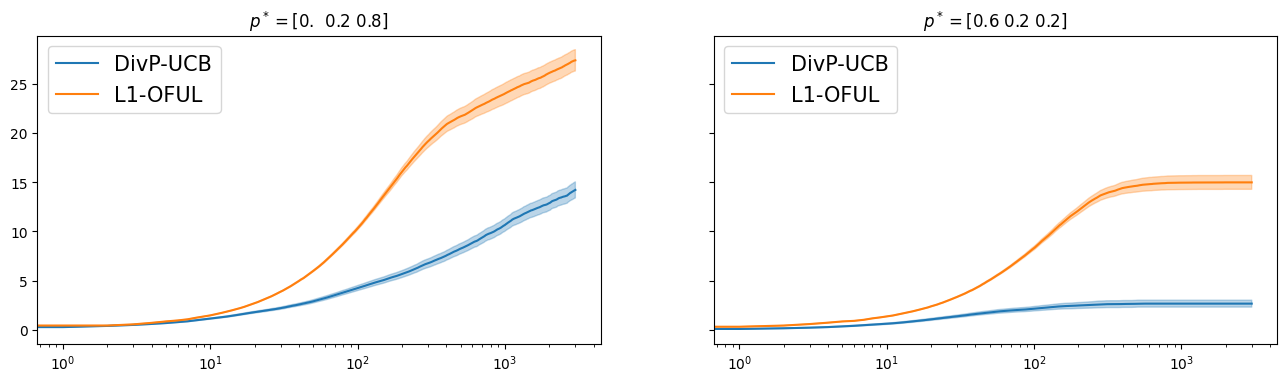

In [188]:
T = 3000

eps = 1.
alg_list = [
            # algs.DivPUCB(K, C, label='DivP-UCB1', sig=1/2, noise="gaussian"),
            # algs.DivPUCB(K, C, label='DivP-UCB2', sig=1/(2 * np.sqrt(2)), noise="gaussian"),
            algs.DivPUCB(K, C, label='DivP-UCB', sig=1/(4), noise="gaussian"),
            # algs.L1OFUL(K, C, label="L1-OFUL1", delta=3 / ( T)),
            # algs.L1OFUL(K, C, label="L1-OFUL2", delta=1 / (3 * T)),
            algs.L1OFUL(K, C, label="L1-OFUL", delta=0),
            # algs.DivPEpsGreedy(K, C, label=r'$\epsilon$-greedy, $\epsilon=$'+str(eps), epsilon=eps), 
           ]

N_tests = [300 for _ in band_list]

data_dict={
        'name':'Transition from logarithmic to bounded regret',
        'short_name':'logvbounded_FTL',
        'T':T,
        'N_tests':N_tests,
        'band_list':band_list,
        'alg_list':alg_list,
        'results':None,   
        'folder': '../figures/diversity/',
    }

launch(data_dict, checkpoints=False)


skips = []
plot_and_save(data_dict,
                save_figure=False,
                skip_algs=skips,
                log_scale=True,
                show_vars=True,
                clean=True
                )


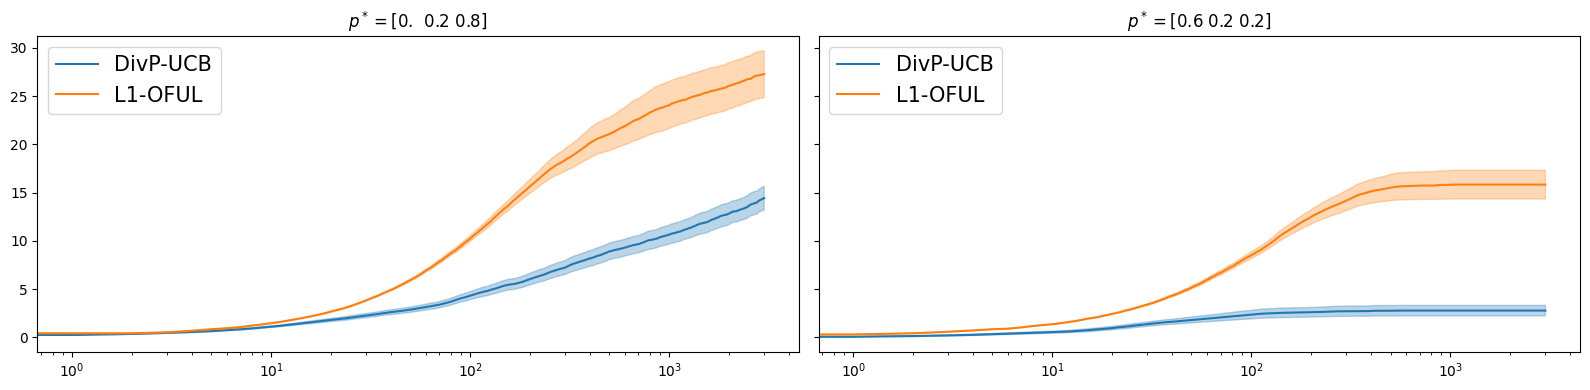

In [187]:
# data_dict["alg_list"][0].label = 'DivP-UCB'
# data_dict["alg_list"][1].label = 'L1-OFUL'


plot_and_save(data_dict,
                save_figure=True,
                log_scale=True,
                show_vars=True,
                clean=True
                )

# General constraints

## Mode d'emploi : 

La cellule juste en dessous sert à générer un problème de bandit. Comme on génère les contraintes aléatoirement, il se peut qu'elles ne soient pas réalisables. Dans ce cas il faut relancer la cellule jusqu'à ce qu'elle affiche ''Optimization terminated successfully.''

K est la dimension du problème
n_cons le nombre de contraintes
C est un objet contrainte, qui implémente les fonctions de base, en particulier optimiser. Pour l'initialiser, on donne une liste de triplets $\big($l(ower), u(pper), s$\big)$ où s est un vecteur dans $\{0, 1\}^K$

In [ ]:
K = 5

mus = np.random.rand(K)
mus_list = [mus]

n_cons = 3
constraints_list = [(0.7*np.random.rand(), 1,np.array([1*(np.random.rand() > 1/2) for _ in range(K)])) for _ in range(n_cons)]
C = PolytopeConstraints(K, constraints_list)

band_list = [FairBand(K, mus, C, noise=noise)]

min_reward = C.argmax_dot(-mus)
max_reward = C.argmax_dot(mus)
print(max_reward)
delta_max =  max_reward.fun - (- min_reward.fun)
print("Un point qui vérifie les contraintes : ", C.feasible)
print("Ecart maximum pour ce problème : ", delta_max)

Ici on met la liste d'algorithmes que l'on souhaite tester

In [ ]:
T = 5000

alg_list = [FairUCB(K, C, label='FairUCB'),
            L1OFUL(K, C, label='OFUL', delta=1/T),
           ]

data_dict={
        'name':'General case',
        'short_name':'gen_case',
        'T':T,
        'Ntest':Ntest,
        'band_list':band_list,
        'alg_list':alg_list,
        'results':None,   
    }

launch(data_dict, fair_reg=True)

In [ ]:
print(data_dict['name'])
plot_and_save(data_dict, save_data=False, skip_algs=[1])

print('worst possible perf : ',str(T*delta_max))

In [18]:
a = [1,2,3,4]
b = [5,6]*2
c  = zip(a, b)
print([x for x in c])

[(1, 5), (2, 6), (3, 5), (4, 6)]


In [5]:
ls ../data_saves/continuous

cont_test.pkl


(<Figure size 1152x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x102954f4a8>,
       dtype=object))

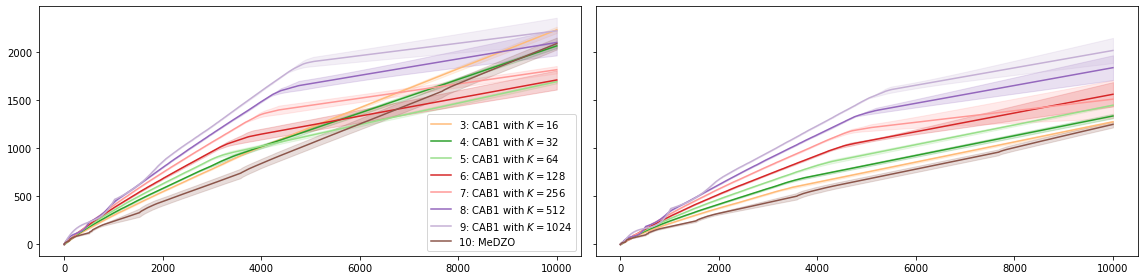

In [26]:
data_dict = load_data_dict('data_saves/continuous/cont_test.pkl')

skips= [0, 1, 2]

plot_and_save(data_dict,
              save_data=False,
              skip_algs=skips,
              log_scale=False)

